In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [2]:
def compute_mse(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    N = y.shape[0]
    
    e = y - np.matmul(tx, w)
    
    return 1.0 / N * np.sum( e ** 2 )

In [3]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    w = np.linalg.inv(tx.T @ tx) @ tx.T @ y
    mse = compute_mse(y, tx, w)
    return w, mse

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [6]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    gs_w = np.array([66.67, 16.67])
    gd_w = np.array([73.29, 13.48])
    
    gs_mse = compute_mse(y, tx, gs_w)
    gd_mse = compute_mse(y, tx, gd_w)
    
    ls_w, ls_mse = least_squares(y, tx)
    
    return f"Grid search MSE: {gs_mse}, Gradient Descent MSE: {gd_mse}, Least squares MSE: {ls_mse}"

Test it here

In [7]:
test_your_least_squares()

'Grid search MSE: 84.82605317509557, Gradient Descent MSE: 30.77179120245295, Least squares MSE: 30.771775737658803'

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [8]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [10]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    return np.array([x ** j for j in range(degree + 1)]).T

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [13]:
from plots import *
def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        tx = build_poly(x, degree)
        weights, mse = least_squares(y, tx)
        rmse = np.sqrt(2 * mse)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.6673335515781588
Processing 2th experiment, degree=3, rmse=0.36569126977323685
Processing 3th experiment, degree=7, rmse=0.353070724608448
Processing 4th experiment, degree=12, rmse=0.39181041436677455


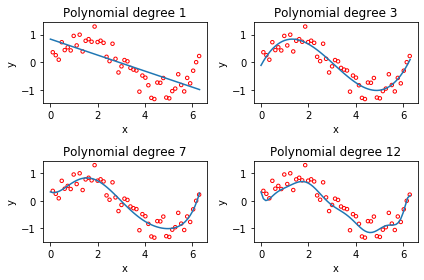

In [14]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [15]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    sz = x.shape[0]
    idx = list(np.random.choice(sz, int(sz * ratio), replace=False))
    i_idx = list(set(range(sz)) - set(idx))
    return x[idx], y[idx], x[i_idx], y[i_idx]

Then, test your `split_data` function below.

In [18]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    x_train, y_train, x_test, y_test = split_data(x, y, ratio)
    
    tx_train = build_poly(x_train, degree)
    tx_test = build_poly(x_test, degree)
    
    weights, mse = least_squares(y_train, tx_train)

    rmse_tr = np.sqrt(2 * mse)
    rmse_te = np.sqrt(2 * compute_mse(y_test, tx_test, weights))
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))

In [19]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.643, Testing RMSE=0.879
proportion=0.9, degree=3, Training RMSE=0.374, Testing RMSE=0.302
proportion=0.9, degree=7, Training RMSE=0.363, Testing RMSE=0.268
proportion=0.9, degree=12, Training RMSE=0.685, Testing RMSE=0.800
proportion=0.5, degree=1, Training RMSE=0.565, Testing RMSE=0.783
proportion=0.5, degree=3, Training RMSE=0.335, Testing RMSE=0.433
proportion=0.5, degree=7, Training RMSE=0.309, Testing RMSE=0.475
proportion=0.5, degree=12, Training RMSE=0.422, Testing RMSE=0.674
proportion=0.1, degree=1, Training RMSE=0.641, Testing RMSE=1.057
proportion=0.1, degree=3, Training RMSE=0.157, Testing RMSE=0.953
proportion=0.1, degree=7, Training RMSE=13.825, Testing RMSE=138.006
proportion=0.1, degree=12, Training RMSE=2.886, Testing RMSE=87.638


# 3 Ridge Regression
Please fill in the function below.

In [40]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    N, D = tx.shape
    w = np.linalg.inv(tx.T @ tx + 2 * N * lambda_ * np.identity(D)) @ tx.T @ y
    mse = compute_mse(y, tx, w)
    return w, mse

In [41]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)

    x_train, y_train, x_test, y_test = split_data(x, y, ratio)

    tx_train = build_poly(x_train, degree)
    tx_test = build_poly(x_test, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        weights, mse = ridge_regression(y_train, tx_train, lambda_)
        
        rmse_tr.append(np.sqrt(2 * mse))
        rmse_te.append(np.sqrt(2 * compute_mse(y_test, tx_test, weights)))
        
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.312, Testing RMSE=0.452
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.315, Testing RMSE=0.451
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.318, Testing RMSE=0.455
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.320, Testing RMSE=0.459
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.321, Testing RMSE=0.463
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.322, Testing RMSE=0.465
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.323, Testing RMSE=0.466
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.323, Testing RMSE=0.463
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.324, Testing RMSE=0.451
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.328, Testing RMSE=0.427
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.338, Testing RMSE=0.394
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.366, Testing RMSE=0.377
proportion=0.5, degree=7, lambda=0.193, 

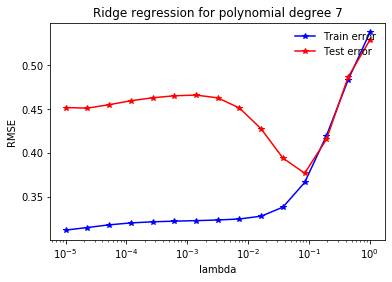

In [42]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)